# Diffusivity tensor for any resolution - Analysis in Zonally Averaged Sense

In [1]:
import numpy as np
import xarray as xr
from funcs import *
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm

In [2]:
Lcoarse = 50e3

In [3]:
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_zonal_'+str(int(Lcoarse//1e3))+'km')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_zonal_'+str(int(Lcoarse//1e3))+'km')

In [5]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

In [6]:
[VpCp, WpCp] = get_flux_arrays_2D(Trac_coarse, list_trac, 'p')
[dCdy, dCdz] = get_grad_arrays_2D(Trac_coarse, list_trac)

In [7]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_fast = xr.apply_ufunc(calc_tensor_2D, 
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':2,'j':2})

Ktensor_fast.load() # need to load because we will take transpose and a

CPU times: user 424 ms, sys: 12.6 ms, total: 437 ms
Wall time: 569 ms


In [9]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_slow = xr.apply_ufunc(calc_tensor_2D, 
                       VpCp.sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':2,'j':2})

Ktensor_slow.load() # need to load because we will take transpose and a

CPU times: user 397 ms, sys: 2.9 ms, total: 399 ms
Wall time: 396 ms


In [10]:
lam1 = 1/31104000.
lam2 = 1/186624000.

Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)

In [11]:
Ktensor_corrT = Ktensor_corr.transpose('Z','YCcoarse','j','i')

ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

In [12]:
Ktensor_fastT = Ktensor_fast.transpose('Z','YCcoarse','j','i')

STfast = 0.5*(Ktensor_fast.data + Ktensor_fastT.data)
ATfast = 0.5*(Ktensor_fast.data - Ktensor_fastT.data)

STfast = xr.DataArray(STfast, coords=Ktensor_fast.coords, dims=Ktensor_fast.dims)
ATfast = xr.DataArray(ATfast, coords=Ktensor_fast.coords, dims=Ktensor_fast.dims)

In [13]:
Ktensor_slowT = Ktensor_slow.transpose('Z','YCcoarse','j','i')

STslow = 0.5*(Ktensor_slow.data + Ktensor_slowT.data)
ATslow = 0.5*(Ktensor_slow.data - Ktensor_slowT.data)

STslow = xr.DataArray(STslow, coords=Ktensor_slow.coords, dims=Ktensor_slow.dims)
ATslow = xr.DataArray(ATslow, coords=Ktensor_slow.coords, dims=Ktensor_slow.dims)

In [14]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
    eigenValues, eigenVectors = eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

In [15]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsST, eigvecsST = xr.apply_ufunc(eigen, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [16]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsSTslow, eigvecsSTslow = xr.apply_ufunc(eigen, STslow, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [17]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsSTfast, eigvecsSTfast = xr.apply_ufunc(eigen, STfast, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [18]:
diff_tensor = xr.Dataset()
diff_tensor['Kfast'] = Ktensor_fast
diff_tensor['Kslow'] = Ktensor_slow
diff_tensor['Kcorr'] = Ktensor_corr
diff_tensor['ST'] = ST
diff_tensor['AT'] = AT
diff_tensor['eigvalsST'] = np.real(eigvalsST)
diff_tensor['eigvecsST'] = eigvecsST
diff_tensor['STfast'] = STfast
diff_tensor['ATfast'] = ATfast
diff_tensor['eigvalsSTfast'] = np.real(eigvalsSTfast)
diff_tensor['eigvecsSTfast'] = eigvecsSTfast
diff_tensor['STslow'] = STslow
diff_tensor['ATslow'] = ATslow
diff_tensor['eigvalsSTslow'] = np.real(eigvalsSTslow)
diff_tensor['eigvecsSTslow'] = eigvecsSTslow

In [19]:
diff_tensor.to_netcdf('./outputs_ncfiles/diff_tensor_zonal_'+str(int(Lcoarse//1e3))+'km.nc')

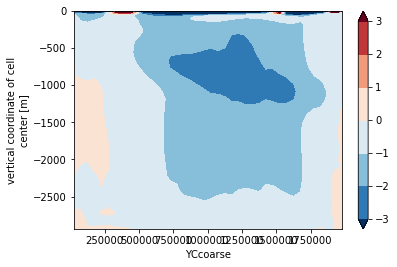

In [20]:
ATfast.isel(i=1,j=0).plot.contourf(vmin=-3)

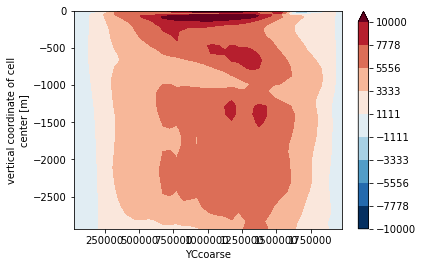

In [22]:
eigvalsST.isel(ii=1).plot.contourf(levels=10, vmin=-10000)

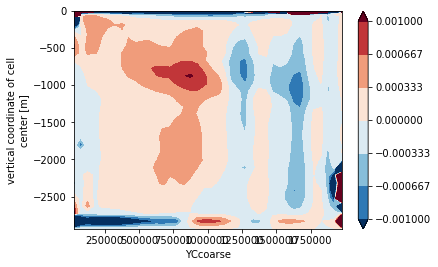

In [23]:
eigvalsST.isel(ii=0).plot.contourf(vmin=-1e-3)